# Continuous Control

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'python')))

from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# # widget bar to display progress
# !pip install progressbar
import progressbar as pb

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_Twenty_Agents/Reacher.x86_64')
# env = UnityEnvironment(file_name='Reacher_Linux_Single_Agent/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment. 

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. Training agent from scratch

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Adapted DDPG algorithm

In [6]:
# Kaiming weight initialization for ReLU activation
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')    

# Actor, Critic classes adapted from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/model.py
# def hidden_init(layer):
#     fan_in = layer.weight.data.size()[0]
#     lim = 1. / np.sqrt(fan_in)
#     return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size),
            nn.Tanh()
        )
        self.reset_parameters()
        
    def reset_parameters(self):        
        self.model.apply(init_weights)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        return self.model(state)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, fc3_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model1 = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU()
        )
        self.model2 = nn.Sequential(
            nn.Linear(fc1_units+action_size, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, 1)
        )
        self.reset_parameters()
        
    def reset_parameters(self):
        self.model1.apply(init_weights)
        self.model2.apply(init_weights)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.model1(state)
        x = torch.cat((xs, action), dim=1)
        return self.model2(x)

In [7]:
BUFFER_SIZE = int(1e6)  # replay buffer size
# WEIGHT_DECAY = 0.0001   # L2 weight decay
WEIGHT_DECAY = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent, OUNoise, and ReplayBuffer classes adapted from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/ddpg_agent.py
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128, fc3_units=128, batch_size=128, gamma=0.99, tau=1e-3, 
                 lr_actor=3e-4, lr_critic=3e-4, random_seed=42, actor_grad_clip=1e-1, critic_grad_clip=1e-1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
            batch_size (int): Batch size during training
            gamma (float): discount rate
            tau (float): rate of mixing local model weights into target model weights during soft update
            lr_actor (float): learning rate for actor networks
            lr_critic (float): learning rate for critic networks
            random_seed (int): random seed
            actor_grad_clip (float): gradient clipping for actor networks
            critic_grad_clip (float) gradient clipping for critic networks

        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.seed = random.seed(random_seed)
        self.actor_grad_clip = actor_grad_clip
        self.critic_grad_clip = critic_grad_clip

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, batch_size, random_seed)
        
        self.hard_update(self.actor_local, self.actor_target)
        self.hard_update(self.critic_local, self.critic_target)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(len(rewards)):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping for more stable training
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.critic_grad_clip)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # Gradient clipping for more stable training
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.actor_grad_clip)
        self.actor_optimizer.step()                  

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    # Hard update to sync the local and target models at the start of training 
    def hard_update(self, local_model, target_model):
        """Hard update model parameters, only called during agent's initialization
        θ_target = θ_local
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
states = env_info.vector_observations                  # get the current state (for each agent)
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

## Hyperparameter Search

Here, I did not conduct a comprehensive hyperparameter search through all possible space of hyperparameters. Instead, I selected a reasonable set of hyperparameters, and experimented with changing only a few hyperparameters at a time. 

Note: The following code blocks take a very long time so feel free to comment them out/skip them.

In [9]:
config_grid = {
    # 'gamma' : [0.99, 0.999],
    # ('fc1_units', 'fc2_units', 'fc3_units') : [(128, 128, 128), (256, 256, 256), (256, 128, 128)],
    # ('actor_grad_clip', 'critic_grad_clip') : [(np.Inf, np.Inf), (np.Inf, 1e-1), (1e-1, 1e-1)],
    # ('tau', 'lr_actor', 'lr_critic'): [(3e-4, 1e-3, 1e-3), (1e-3, 3e-4, 3e-4)],
    'batch_size' : [128, 256, 512]
}

batch_size : 128


Episode 100 Score: 0.3300 Average score over 100 episodes: 0.7388


Episode 200 Score: 1.9690 Average score over 100 episodes: 1.0518


Episode 300 Score: 9.4960 Average score over 100 episodes: 5.9414


Episode 400 Score: 19.2865 Average score over 100 episodes: 13.3705


Episode 500 Score: 20.5845 Average score over 100 episodes: 17.2222


Episode 600 Score: 26.5710 Average score over 100 episodes: 22.2452


Episode 700 Score: 31.3360 Average score over 100 episodes: 28.9253


Episode 800 Score: 29.2385 Average score over 100 episodes: 27.6861
Solved in Episode None
batch_size : 256


Episode 100 Score: 2.0990 Average score over 100 episodes: 1.5611


Episode 200 Score: 8.5100 Average score over 100 episodes: 5.1040


Episode 300 Score: 11.5805 Average score over 100 episodes: 10.1888


Episode 400 Score: 21.9870 Average score over 100 episodes: 15.9129


Episode 500 Score: 31.5470 Average score over 100 episodes: 28.2483


Episode 600 Score: 33.0345 Average score over 100 episodes: 31.7216


Solved in Episode 515
batch_size : 512


Episode 100 Score: 3.8150 Average score over 100 episodes: 2.0243


Episode 200 Score: 21.8230 Average score over 100 episodes: 12.8989


Episode 300 Score: 33.1245 Average score over 100 episodes: 29.9195


Episode 400 Score: 29.8635 Average score over 100 episodes: 29.4486


Solved in Episode 301


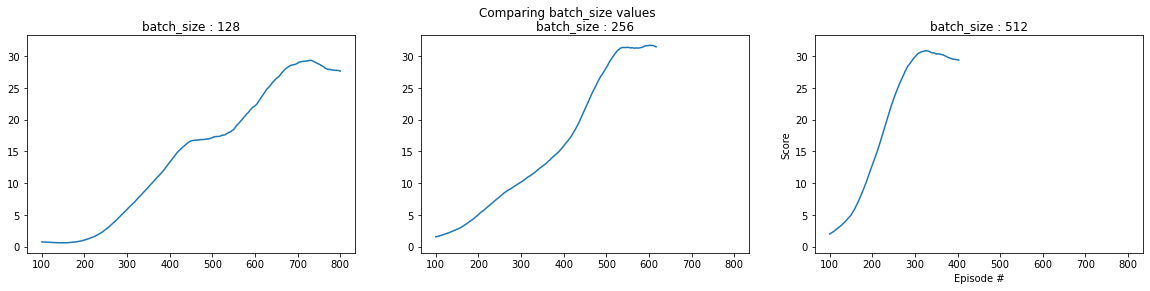

In [10]:
WINDOW = 100
NUM_EPISODES = 800

def smoothed_plot(hparam_key, scores_dict, window=WINDOW):
    axes = [None for i in range(len(scores_dict))]

    fig = plt.figure(figsize=(20,4))
    for i, (hparam_val, scores) in enumerate(scores_dict.items()):
        # sliding window average 
        smoothed_scores = [np.mean(scores[i-window+1:i]) for i in range(window-1, len(scores))]
        # plot the scores
        axes[i] = fig.add_subplot(1, len(scores_dict), i+1)
        # axes[i] = plt.subplot(1, len(scores_dict), i+1)
        axes[i].plot(window+np.arange(len(smoothed_scores)), smoothed_scores)
        axes[i].set_title(f'{hparam_key} : {hparam_val}')
    axes[0].get_shared_x_axes().join(axes[0], *axes[1:])
    axes[0].get_shared_y_axes().join(axes[0], *axes[1:])
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.suptitle(f'Comparing {hparam_key} values')
    plt.show()

for hparam_key, hparam_list in config_grid.items():
    widget = ['training loop: ', pb.Percentage(), ' ', 
              pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=NUM_EPISODES).start()

    # dict of scores by episode for each choice of hyperparameter
    scores_dict = {}
    for hparam_val in hparam_list:
        print(f"{hparam_key} : {hparam_val}")
        if type(hparam_key) == tuple:
            args = dict(zip(hparam_key, hparam_val))
        else:
            args = {hparam_key : hparam_val}

        solved = None
        agent = Agent(state_size, action_size, **args)
        mean_scores = []

        for episode in range(NUM_EPISODES):
            env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
            agent.reset()
            scores = np.zeros(num_agents)                          # initialize the score (for each agent)
            states = env_info.vector_observations
            timestep = 0
            while True:
                timestep += 1
                actions= agent.act(states)    
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                scores += env_info.rewards
                agent.step(states, actions, rewards, next_states, dones)

                # Learn, if enough samples are available in memory
                if len(agent.memory) > agent.batch_size:
                    experiences = agent.memory.sample()
                    agent.learn(experiences, agent.gamma)

                    # update target networks
                    agent.soft_update(agent.critic_local, agent.critic_target, agent.tau)
                    agent.soft_update(agent.actor_local, agent.actor_target, agent.tau)   

                states = next_states                               # roll over states to next time step
                if np.any(dones):                                  # exit loop if episode finished
                    break
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            
            if (episode+1) % WINDOW == 0:
                print(f"Episode {episode+1:03d} Score: {mean_score:.4f} Average score over {WINDOW} episodes: {np.array(mean_scores[-WINDOW:]).mean():.4f}")
            
            # Task is considered "solved" when average reward (over all 20 agents, over 100 episodes) of at least +30 is achieved. 
            if len(mean_scores) > WINDOW and (np.array(mean_scores[-WINDOW:]).mean() > 30) and not solved:
                solved = episode
            # Continue for 100 more episodes after "solving" to assess stability
            if solved and episode > solved + 100:
                break
            timer.update(episode+1)
        print("Solved in Episode {}".format(solved))                
                
        scores_dict[hparam_val] = mean_scores
    smoothed_plot(hparam_key, scores_dict)


Episode 100 Score: 1.7615 Average score over 100 episodes: 1.2784


Episode 200 Score: 9.2855 Average score over 100 episodes: 5.1967


Episode 300 Score: 20.0045 Average score over 100 episodes: 12.6483


Episode 400 Score: 29.0695 Average score over 100 episodes: 25.9080


Episode 500 Score: 32.3585 Average score over 100 episodes: 30.4376


Episode 600 Score: 24.1085 Average score over 100 episodes: 28.3262


Episode 700 Score: 27.9260 Average score over 100 episodes: 26.1686


Episode 800 Score: 26.2395 Average score over 100 episodes: 26.5356
Solved in Episode 482


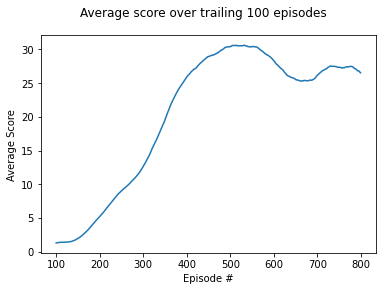

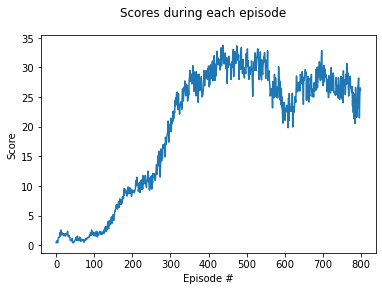

In [11]:
WINDOW = 100
NUM_EPISODES = 800

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=NUM_EPISODES).start()

solved = None
# Choose batch_size=512 to train the final model
args = {'batch_size' : 512}
agent = Agent(state_size, action_size, **args)
mean_scores = []
best_mean_score = 0

for episode in range(NUM_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    agent.reset()
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    states = env_info.vector_observations
    timestep = 0
    while True:
        timestep += 1
        actions= agent.act(states)    
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards
        agent.step(states, actions, rewards, next_states, dones)

        # Learn, if enough samples are available in memory
        if len(agent.memory) > agent.batch_size:
            experiences = agent.memory.sample()
            agent.learn(experiences, agent.gamma)

            # update target networks
            agent.soft_update(agent.critic_local, agent.critic_target, agent.tau)
            agent.soft_update(agent.actor_local, agent.actor_target, agent.tau)   

        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)

    if (episode+1) % WINDOW == 0:
        print(f"Episode {episode+1:03d} Score: {mean_score:.4f} Average score over {WINDOW} episodes: {np.array(mean_scores[-WINDOW:]).mean():.4f}")

    # Task is considered "solved" when average reward (over all 20 agents, over 100 episodes) of at least +30 is achieved. 
    if len(mean_scores) > WINDOW and (np.array(mean_scores[-WINDOW:]).mean() > 30) and not solved:
        solved = episode
    # Once solved, save the weights whenever the best_mean_score (average reward over 20 agents over 100 episodes) is improved:
    if solved and np.array(mean_scores[-WINDOW:]).mean() >= best_mean_score:
        best_mean_score = np.array(mean_scores[-WINDOW:]).mean()
        torch.save(agent.actor_local.state_dict(), f"actor_local_final.pt")
        torch.save(agent.critic_local.state_dict(), f"critic_local_final.pt")
    timer.update(episode+1)
print("Solved in Episode {}".format(solved))               

# sliding window average 
smoothed_scores = [np.mean(mean_scores[i-100:i]) for i in range(100, len(mean_scores))]
# plot the sliding window averaged scores
plt.plot(100+np.arange(len(smoothed_scores)), smoothed_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.suptitle(f'Average score over trailing 100 episodes')
plt.show()

plt.plot(np.arange(len(mean_scores)), mean_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.suptitle(f'Scores during each episode')
plt.show()

### Load trained model

Here, you can load the pre-trained weights to observe the trained agent's policy in the environment.

In [12]:
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size)
agent.actor_local.load_state_dict(torch.load('actor_local_final.pt', map_location="cuda:0" if torch.cuda.is_available() else "cpu"))
agent.critic_local.load_state_dict(torch.load('critic_local_final.pt', map_location="cuda:0" if torch.cuda.is_available() else "cpu"))

In [13]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
agent.reset()
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
states = env_info.vector_observations
timestep = 0
while True:
    timestep += 1
    actions= agent.act(states)    
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards
    agent.step(states, actions, rewards, next_states, dones)

    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {0:.4f}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 30.6695


## Shut down the Environment

When finished, you can close the environment.

In [14]:
env.close()